# Projet Apprentissage Supervisée: Change detection in bi-temporal remote sensing image 

### Clément Guigon - Ophélia Urbing - Etienne Bardet

#### Libraries

In [136]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TVF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from network import *
from network2 import *
from tqdm import tqdm
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#### Dataset

In [138]:
#Simple Dataset class for our change detection dataset

class ChangeDetectionDataset(Dataset):
    def __init__(self, csv_file="data.csv", data_dir="./data", batch_size=1, transform=None, crop_size=128):
        #repeat the data 5 times to have more data
        self.data = pd.read_csv(csv_file).sample(frac=20, replace=True)
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.crop_size = crop_size
    def __len__(self):
        return len(self.data)

    def random_crop(self, img1, img2, cm, size):
        x = np.random.randint(0, img1.shape[2]-size)
        y = np.random.randint(0, img1.shape[1]-size)
        img1 = img1[:,y:y+size, x:x+size]
        img2 = img2[:,y:y+size, x:x+size]
        cm = cm[0:1, y:y+size, x:x+size]
        return img1, img2, cm

    def random_flip(self, img1,img2,cm, chance=0.5):
        if (np.random.randint(0,1)> chance):
            img1 = TVF.hflip(img1)
            img2 = TVF.hflip(img2)
            cm = TVF.hflip(cm)

        if (np.random.randint(0,1)> chance):
            img1 = TVF.vflip(img1)
            img2 = TVF.vflip(img2)
            cm = TVF.vflip(cm)

        return img1, img2, cm

    def __getitem__(self, idx):
        img1 = read_image(self.data_dir+'/'+self.data.iloc[idx,0])
        img2 = read_image(self.data_dir+'/'+self.data.iloc[idx,1])
        cm = read_image(self.data_dir+'/'+self.data.iloc[idx,2])

        img1Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        img2Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        cmTensor = torch.zeros((1, self.crop_size, self.crop_size), dtype=torch.float32)
        
        crop1, crop2, cropcm = self.random_crop(img1[:,:,:], img2[:,:,:], cm[:,:,:], self.crop_size)
        crop1, crop2, cropcm = self.random_flip(crop1[:,:,:], crop2[:,:,:], cropcm[:,:,:])
        img1Tensor[:,:,:] = crop1.float()/255
        img2Tensor[:,:,:] = crop2.float()/255
        cmTensor[:,:,:] = cropcm.float()/255
        #apply the same transformation to all images as batch dimension
        return img1Tensor, img2Tensor, cmTensor
        

#### DataLoader class for our change detection dataset

In [139]:
#Simple DataLoader class for our change detection dataset
batch_size = 16

weights = class_weights("data.csv")
weights = torch.tensor(weights[1]/weights[0]).to(device)

train_dataset= ChangeDetectionDataset(data_dir="data",csv_file="train.csv", batch_size=batch_size, transform=None)
val_dataset = ChangeDetectionDataset(data_dir="data",csv_file="val.csv", batch_size=1, transform=None)
train_loader = DataLoader(batch_size=batch_size, dataset=train_dataset, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=True)


C:\Users\urbin\AppData\Local\Temp\ipykernel_15200\1379264822.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights[1]/weights[0]).to(device)


#### Function to display a batch of images

In [140]:
#Simple function to display a batch of images

def show_batch(batch):
    img1s, img2s, cms = batch

    for i in range(len(img1s)):
        img1 = img1s[i,:,:,:]
        img2 = img2s[i,:,:,:]
        cm = cms[i,:,:,:]
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(img1.permute(1,2,0))
        ax[1].imshow(img2.permute(1,2,0))
        ax[2].imshow(cm.permute(1,2,0), cmap='gray')
        plt.show()
# a = next(iter(train_loader))
# show_batch(a)

#### Model

In [141]:
n_epoch = 15
learning_rate = 0.0001
model = ADSNet(base_channels=32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss, val_loss = [], []
train_precision, val_precision = [], []
model = model.to(device)
best_loss =1000


for epoch in range(n_epoch):
    model.train()
    loss_cumu = 0
    prec = 0
    for img1, img2, cm in tqdm(train_loader, ascii=" >="):
        img1, img2, cm = img1.to(device), img2.to(device), cm.to(device)

        # input_combined = torch.cat((img1, img2), dim=1)  # Concaténation des deux images sur le canal

        # Forward pass
        y_pred, _ = model(img1, img2)
        loss = loss_fn(y_pred, cm)  # Supervision profonde
        loss_cumu += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Précision
        pred_binary = torch.round(torch.sigmoid(y_pred))
        prec += torch.sum(pred_binary * cm) / (torch.sum(cm) + 1)
    
    train_loss.append(loss_cumu / len(train_loader))
    train_precision.append(prec / len(train_loader))

    # Validation
    model.eval()
    loss_cumu = 0
    prec = 0
    with torch.no_grad():
        for img1, img2, cm in val_loader:
            img1, img2, cm = img1.to(device), img2.to(device), cm.to(device)
            
            #input_combined = torch.cat((img1, img2), dim=1)  # Concaténation des deux images sur le canal
            
            y_pred, _ = model(img1, img2)
            loss = loss_fn(y_pred, cm)
            loss_cumu += loss.item()

            pred_binary = torch.round(torch.sigmoid(y_pred))
            prec += torch.sum(pred_binary * cm) / (torch.sum(cm) + 1)

            # Sauvegarde du meilleur modèle
            if loss_cumu / len(val_loader) < best_loss:
                best_loss = loss_cumu / len(val_loader)
                torch.save(model.state_dict(), "best_model.pt")
        
        val_loss.append(loss_cumu / len(val_loader))
        val_precision.append(prec / len(val_loader))
    
    print(f"Epoch {epoch+1} : Training, loss: {train_loss[-1]:.4f}, precision: {train_precision[-1]:.4f} | Validation, loss: {val_loss[-1]:.4f}, precision: {val_precision[-1]:.4f}")

NameError: name 'ADSNet' is not defined

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

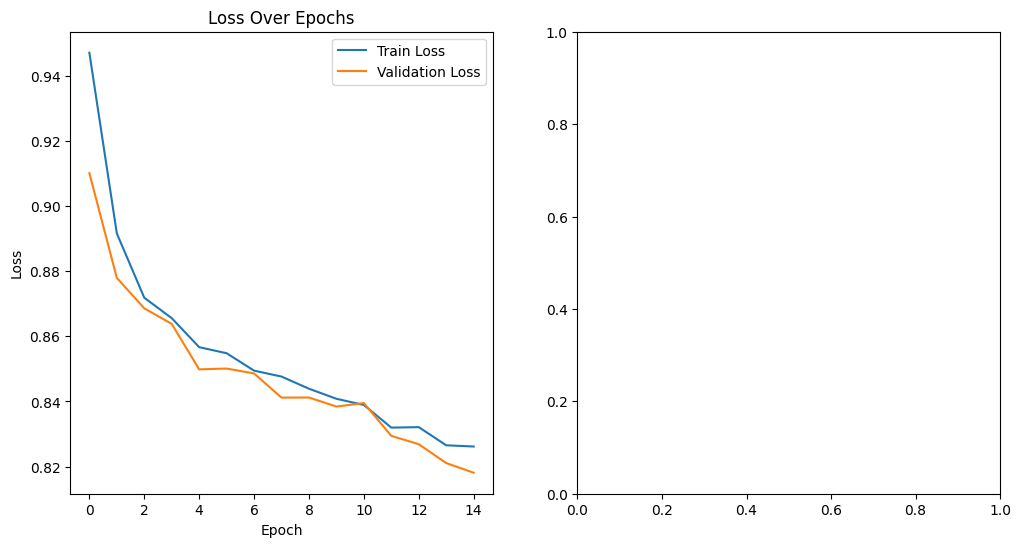

In [ ]:
# Affichage des courbes
plt.figure(figsize=(12, 6))

# Courbes de perte
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Courbes de précision
plt.subplot(1, 2, 2)
plt.plot(train_precision, label='Train Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Inference
model.cpu()
model.eval()

# Exemple avec une batch du train_loader
im1, im2, cm = next(iter(train_loader))

# Prévision et binarisation
cm_pred_logits= model(im1, im2)  # Logits prédits
cm_pred_prob = torch.sigmoid(cm_pred_logits)  # Conversion en probabilités

print("Max:", torch.max(cm_pred_prob).item(), "Min:", torch.min(cm_pred_prob).item())

cm_pred_binary = (cm_pred_prob > 0.5)  # Conversion en binaire

# Affichage des résultats
plt.figure()
plt.subplot(1, 3, 1)
plt.title("Ground Truth (CM)")
plt.imshow(cm[0].permute(1, 2, 0).cpu(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Probabilités (Pred)")
plt.imshow(cm_pred_prob.detach()[0].permute(1, 2, 0).cpu(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Binaire (Pred)")
plt.imshow(cm_pred_binary.detach()[0].permute(1, 2, 0).cpu(), cmap='gray')
plt.show()

# Affichage des deux images d'entrée
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Image 1")
plt.imshow(im1[0].permute(1, 2, 0).cpu())
plt.subplot(1, 2, 2)
plt.title("Image 2")
plt.imshow(im2[0].permute(1, 2, 0).cpu())
plt.show()

AttributeError: 'collections.OrderedDict' object has no attribute 'cpu'

In [ ]:
model = torch.load("best_model.pt")
model.eval()

C:\Users\urbin\AppData\Local\Temp\ipykernel_15200\1727061402.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_model.pt")


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

# Notes
U-Net peut être utile

# Soutenance
 - Explication du problème et comment le transcrire
 - Pré-traitement des données
 - Architecture du réseau
 - Présentation des résultats
 
# Rendu 
 - Slides de présentation (10 minutes+ 10 min de questions)
 - Notebook avec le code

À rendre en séance. 